In [1]:
import os
import sys
import glob
import shutil
import numpy as np
import pandas as pd
import tqdm

import time
import datetime

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
# import tensorflow_datasets as tfds

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

2023-11-08 02:37:07.692929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2


### Now time

In [2]:
# now_time
d = datetime.datetime.now()
now_time = f"{d.year}-{d.month}-{d.day}-{d.hour}-{d.minute}-{d.second}"

now_time_path = os.path.join("..", "exp", now_time)

if not os.path.exists(now_time_path):
    os.mkdir(now_time_path)
    os.mkdir(os.path.join(now_time_path, "save_img"))
    os.mkdir(os.path.join(now_time_path, "model_checkpoints"))

### Dateload

In [3]:
# dataload
base_path = os.path.join("..", "data", "01_NBI")

# nbi data load
nbi_cancer_path = glob.glob(os.path.join(base_path, "nbi", "00_cancer", "*.jpg"))
nbi_ulcer_path = glob.glob(os.path.join(base_path, "nbi", "01_ulcer", "*.jpg"))
nbi_normal_path = glob.glob(os.path.join(base_path, "nbi", "02_normal", "*.jpg"))
nbi_adenoma_path = glob.glob(os.path.join(base_path, "nbi", "03_adenoma", "*.jpg"))

nbi_total_path = nbi_cancer_path + nbi_ulcer_path + nbi_normal_path + nbi_adenoma_path

print("number of nbi 00_cancer paths:", len(nbi_cancer_path))
print("number of nbi 01_ulcer paths:", len(nbi_ulcer_path))
print("number of nbi 02_normal paths:", len(nbi_normal_path))
print("number of nbi 03_adenoma paths:", len(nbi_adenoma_path))
print("number of nbi total paths:", len(nbi_total_path))

# original data load
ori_cancer_path = glob.glob(os.path.join(base_path, "ori", "00_cancer", "*.jpg"))
ori_ulcer_path = glob.glob(os.path.join(base_path, "ori", "01_ulcer", "*.jpg"))
ori_normal_path = glob.glob(os.path.join(base_path, "ori", "02_normal", "*.jpg"))
ori_adenoma_path = glob.glob(os.path.join(base_path, "ori", "03_adenoma", "*.jpg"))

ori_total_path = ori_cancer_path + ori_ulcer_path + ori_normal_path + ori_adenoma_path

print("number of ori 00_cancer paths:", len(ori_cancer_path))
print("number of ori 01_ulcer paths:", len(ori_ulcer_path))
print("number of ori 02_normal paths:", len(ori_normal_path))
print("number of ori 03_adenoma paths:", len(ori_adenoma_path))
print("number of ori total paths:", len(ori_total_path))

number of nbi 00_cancer paths: 579
number of nbi 01_ulcer paths: 74
number of nbi 02_normal paths: 300
number of nbi 03_adenoma paths: 1175
number of nbi total paths: 2128
number of ori 00_cancer paths: 1307
number of ori 01_ulcer paths: 266
number of ori 02_normal paths: 5187
number of ori 03_adenoma paths: 2066
number of ori total paths: 8826


### Prepare Sample dataset

In [4]:
train_ori_paths = ori_total_path[:40]
train_nbi_paths = nbi_total_path[:40]

test_ori_paths = ori_total_path[40:60]
test_nbi_paths = nbi_total_path[40:60]

train_ori_imgs = np.array([mpimg.imread(path) for path in train_ori_paths])
train_nbi_imgs = np.array([mpimg.imread(path) for path in train_nbi_paths])

test_ori_imgs = np.array([mpimg.imread(path) for path in test_ori_paths])
test_nbi_imgs = np.array([mpimg.imread(path) for path in test_nbi_paths])

print("number of train ori_imgs:", len(train_ori_imgs))
print("number of train nbi_imgs:", len(train_nbi_imgs))
print("number of test ori_imgs:", len(test_ori_imgs))
print("number of test nbi_imgs:", len(test_nbi_imgs))

/root/anaconda3/envs/nipa/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/root/anaconda3/envs/nipa/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/root/anaconda3/envs/nipa/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

number of train ori_imgs: 40
number of train nbi_imgs: 40
number of test ori_imgs: 20
number of test nbi_imgs: 20


/root/anaconda3/envs/nipa/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


### Prepare the dataset

In [5]:
# Define the standard image size.
orig_img_size = (286, 286)
# orig_img_size = (1144, 1144)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# input_img_size = (1024, 1024, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 8


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    # if want batch_size 1, do expand dim
    if batch_size == 1:
        img = tf.expand_dims(img, axis=0)
    return img


def preprocess_test_image(img):
    
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    if batch_size == 1:
        img = tf.expand_dims(img, axis=0)
    return img

### Create Dataset object

In [6]:
# Apply the preprocessing operations to the training data
train_ori = tf.data.Dataset.from_tensor_slices(np.array(list(map(preprocess_train_image, train_ori_imgs))))
train_nbi = tf.data.Dataset.from_tensor_slices(np.array(list(map(preprocess_train_image, train_nbi_imgs))))

if batch_size != 1:
    train_ori = train_ori.shuffle(buffer_size=buffer_size)
    train_ori = train_ori.batch(batch_size)

    train_nbi = train_nbi.shuffle(buffer_size=buffer_size)
    train_nbi = train_nbi.batch(batch_size)

# Apply the preprocessing operations to the test data
test_ori = tf.data.Dataset.from_tensor_slices(np.array(list(map(preprocess_train_image, test_ori_imgs))))
test_nbi = tf.data.Dataset.from_tensor_slices(np.array(list(map(preprocess_train_image, test_nbi_imgs))))

if batch_size != 1:
    test_ori = test_ori.shuffle(buffer_size=buffer_size)
    test_ori = test_ori.batch(batch_size)

    test_nbi = test_nbi.shuffle(buffer_size=buffer_size)
    test_nbi = test_nbi.batch(batch_size)


2023-11-08 02:37:15.200983: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-08 02:37:15.204794: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-08 02:37:15.276621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0004:05:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.50GiB deviceMemoryBandwidth: 836.37GiB/s
2023-11-08 02:37:15.276650: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2023-11-08 02:37:15.277594: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-11-08 02:37:15.277629: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

### Visualize some samples

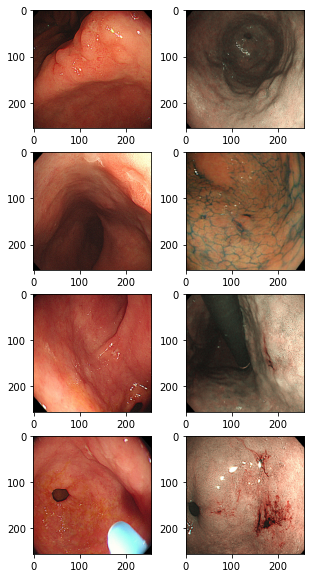

In [7]:
_, ax = plt.subplots(4,2, figsize=(5,10))

for i, samples in enumerate(zip(train_ori.take(4), train_nbi.take(4))):
    ori = ((samples[0][0] * 127.5 + 127.5).numpy()).astype(np.uint8)
    nbi = ((samples[1][0] * 127.5 + 127.5).numpy()).astype(np.uint8)
    
    ax[i, 0].imshow(ori)
    ax[i, 1].imshow(nbi)

plt.show()

### Building blocks used in the CycleGAN generators and discriminators

In [8]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

### Build the generators

In [9]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

### Build the discriminators

In [10]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

### Build the CycleGAN model

In [11]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

### Create a callback that periodically saves generated images

In [12]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(5, 10))
        for i, img in enumerate(test_ori.take(self.num_img)):
        # for i, img in enumerate(test_ori[:self.num_img]):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.img_to_array(prediction)
            
            normalized_prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())
            
            save_img_path = os.path.join(now_time_path, "save_img", 
                                         "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
            
            mpimg.imsave(save_img_path,
                         normalized_prediction
            )

        plt.show()
        plt.close()

### Train the end-to-end model

2023-11-08 02:38:09.360274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-11-08 02:38:09.759742: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2023-11-08 02:38:25.016921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-11-08 02:38:26.026875: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.115, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2023-11-08 02:38:26.113288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


5/5 [==============================] - 72s 1s/step - G_loss: 7.3299 - F_loss: 8.1073 - D_X_loss: 0.4742 - D_Y_loss: 0.4743


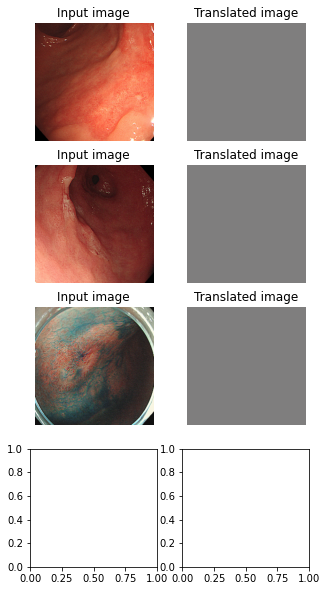

In [13]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = os.path.join(now_time_path, "model_checkpoints", "cyclegan_checkpoints.{epoch:03d}")
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_ori, train_nbi)),
    epochs=1,
    callbacks=[plotter, model_checkpoint_callback],
)
